<a href="https://colab.research.google.com/github/airbytehq/quickstarts/blob/master/pyairbyte_notebooks/PyAirbyte_CoinAPI_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In this demo, we use PyAirbyte to extract cryptocurrency data from [CoinAPI.io](https://www.coinapi.io/), followed by a series of transformations and analyses to derive meaningful insights from this data.

The only prerequisite is a CoinAPI [API key](https://www.coinapi.io/get-free-api-key?product_id=market-data-api).


### Installing PyAirbyte


In [ ]:
# Add virtual environment support in Google Colab
!apt-get install -qq python3.10-venv

# Install PyAirbyte
%pip install --quiet airbyte

### Load source data from CoinAPI.io to local cache

In this section, we establish a connection to CoinAPI.io to access cryptocurrency data via PyAirbyte. The connector is configured with necessary parameters like the API key, environment setting, symbol ID for the specific cryptocurrency index (in this case, `COINBASE_SPOT_INDEX_USD`), and the data period we are interested in. [Check the docs](https://docs.airbyte.com/integrations/sources/coin-api) for more details.

After configuring the source connector, we perform a check to ensure that the configuration is correct and the connection to the API is successful. Then, we proceed to read from the source into the internal DuckDB cache. The `read()` retrieves all available streams from the source.

Note: The credentials are retrieved securely using the `get_secret()` method. This will automatically locate a matching Google Colab secret or environment variable, ensuring they are not hard-coded into the notebook. Make sure to add your key to the Secrets section on the left.


In [ ]:
import airbyte as ab

# Create and configure the source connector:
source = ab.get_source(
    "source-coin-api",
    config={
        "api_key": ab.get_secret("COIN_API_KEY"),
        "environment": "production",
        "symbol_id": "COINBASE_SPOT_INDEX_USD",
        "period": "1DAY",
        "start_date": "2023-01-01T00:00:00",
    },
    streams="*",
)

# Verify the config and creds by running `check`:
source.check()

In [ ]:
# Read data from the source into the default cache:
cache = ab.get_default_cache()
result = source.read(cache=cache)

### Read data from the cache

Read from the already-written DuckDB cache into a pandas Dataframe. After the data is in the cache, you can read it without re-configuring or re-creating the source object. You can also select a stream to read from.


In [ ]:
# Read from the cache into a pandas Dataframe:
ohlcv_df = cache["ohlcv_historical_data"].to_pandas()

### Run data transformations

In this section, we're transforming our data for analysis:

-   Convert `time_period_start` to datetime for easy handling of dates.
-   Convert numeric columns to numeric types for calculations.
-   Calculate `daily_movement` to analyze daily price changes in the market.


In [ ]:
import pandas as pd

# Convert 'time_period_start' to datetime format and necessary columns to numeric
ohlcv_df["time_period_start"] = pd.to_datetime(ohlcv_df["time_period_start"])
numeric_columns = [
    "price_open",
    "price_high",
    "price_low",
    "price_close",
    "volume_traded",
    "trades_count",
]
ohlcv_df[numeric_columns] = ohlcv_df[numeric_columns].apply(
    pd.to_numeric, errors="coerce"
)

# Calculate daily price movement
ohlcv_df["daily_movement"] = ohlcv_df["price_close"] - ohlcv_df["price_open"]

### Analyze the data

Now, we delve into visual analysis:

-   We plot the `daily_movement` to observe day-to-day price changes.
-   A dual-axis plot is created to compare 'price_close' with `volume_traded`, helping us see the relation between price and trading volume.
-   We calculate and plot 7-day and 30-day moving averages alongside the closing price to identify trends and potential crossovers.

These visualizations help us understanding market behaviors and trends in the data.


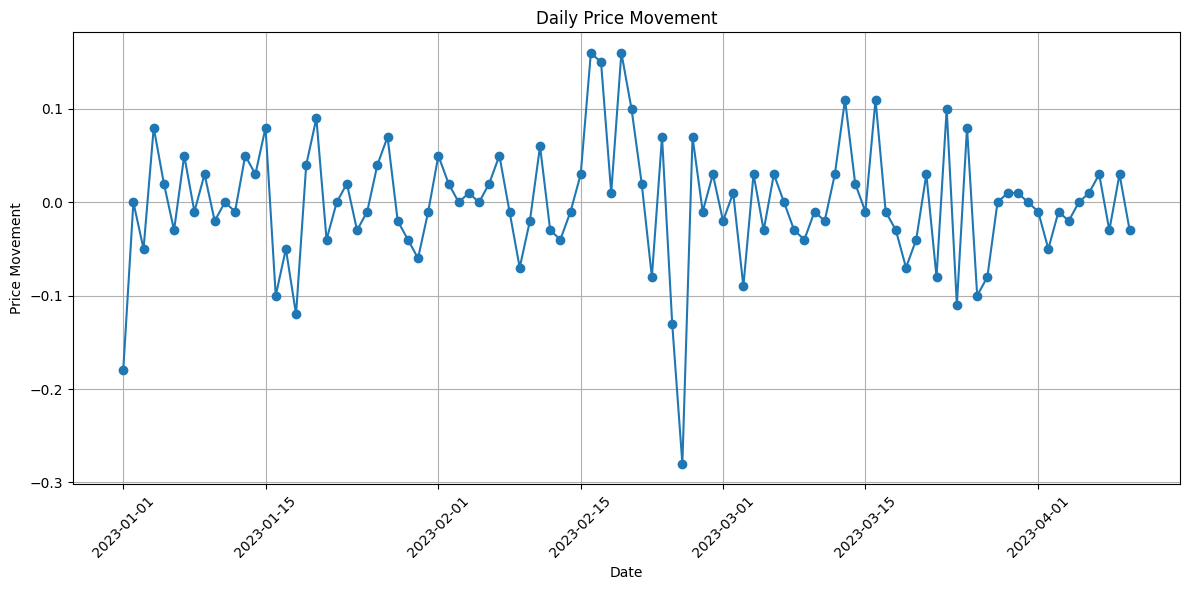

In [ ]:
import matplotlib.pyplot as plt

# Set the 'time_period_start' column as the index for plotting
ohlcv_df.set_index("time_period_start", inplace=True)

# Plotting the daily movement
plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(ohlcv_df["daily_movement"], marker="o", linestyle="-")
plt.title("Daily Price Movement")
plt.xlabel("Date")
plt.ylabel("Price Movement")
plt.grid(True)
plt.xticks(rotation=45)  # Rotates the date labels for better readability
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.show()

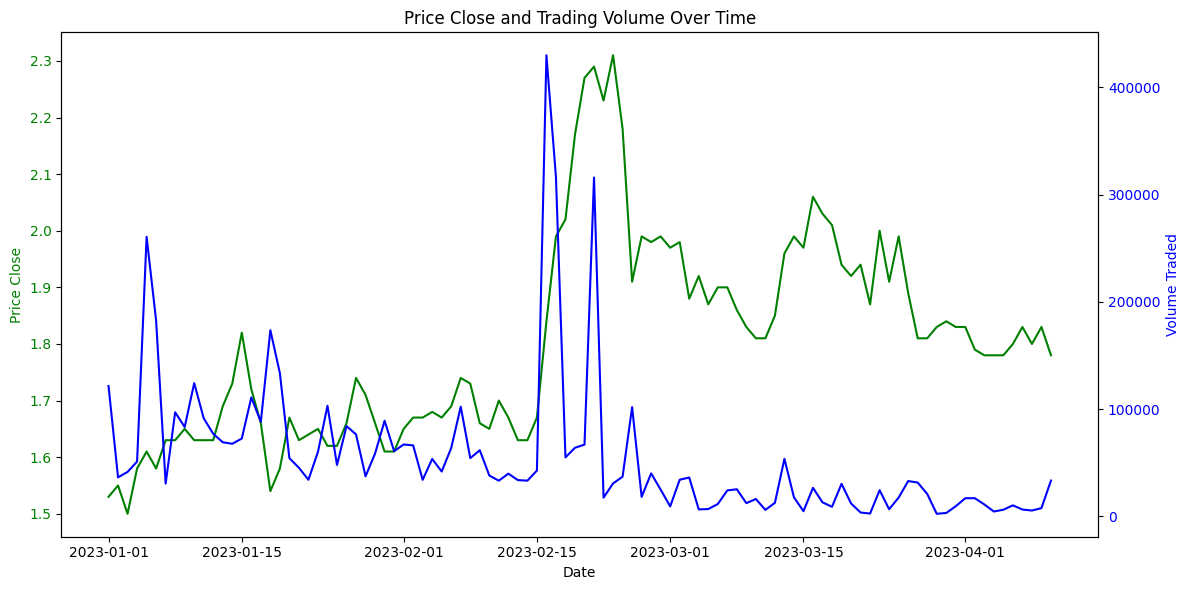

In [ ]:
# Create a dual-axis plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting price close on the first axis
ax1.set_xlabel("Date")
ax1.set_ylabel("Price Close", color="green")
ax1.plot(ohlcv_df["price_close"], color="green")
ax1.tick_params(axis="y", labelcolor="green")

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()
ax2.set_ylabel("Volume Traded", color="blue")
ax2.plot(ohlcv_df["volume_traded"], color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# Title and layout
plt.title("Price Close and Trading Volume Over Time")
fig.tight_layout()
plt.show()

In [ ]:
# Calculate 7-day and 30-day moving averages
ohlcv_df["7_day_MA"] = ohlcv_df["price_close"].rolling(window=7).mean()
ohlcv_df["30_day_MA"] = ohlcv_df["price_close"].rolling(window=30).mean()

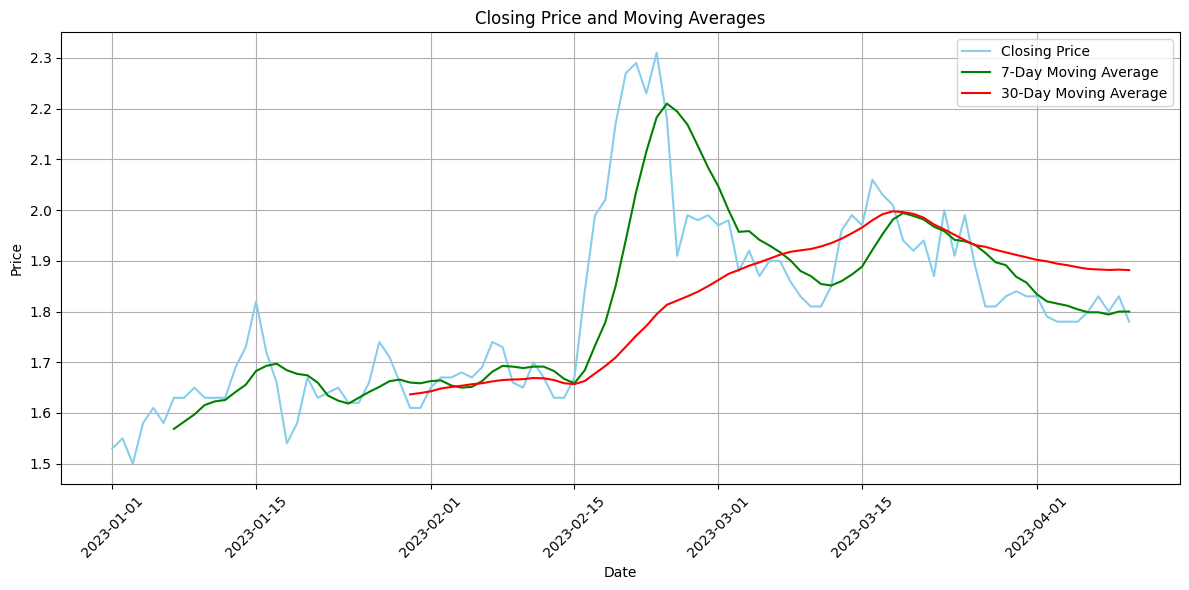

In [ ]:
# Plotting moving averages
plt.figure(figsize=(12, 6))
plt.plot(ohlcv_df["price_close"], label="Closing Price", color="skyblue")
plt.plot(ohlcv_df["7_day_MA"], label="7-Day Moving Average", color="green")
plt.plot(ohlcv_df["30_day_MA"], label="30-Day Moving Average", color="red")

plt.title("Closing Price and Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()